In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [2]:
df = pd.read_csv("../data/NBA_2024_Shots.csv")

In [18]:
X = df.drop(columns=["SHOT_MADE", "EVENT_TYPE"])
y = df['SHOT_MADE']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Columns you want to drop
drop_cols = [
    'SEASON_2', 'TEAM_NAME', 'PLAYER_NAME', 'PLAYER_ID', 'TEAM_ID',
    'GAME_DATE', 'GAME_ID', 'HOME_TEAM', 'AWAY_TEAM',
    'POSITION_GROUP', 'POSITION', 'ZONE_NAME', 'ZONE_ABB', 'EVENT_TYPE'
]

drop_cols = [col for col in drop_cols if col in X_train.columns]

X_train = X_train.drop(columns=drop_cols)
X_test = X_test.drop(columns=drop_cols)


cat_cols = ['ACTION_TYPE', 'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_RANGE']

for col in cat_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

print(X_train.dtypes)

SEASON_1           int64
ACTION_TYPE        int64
SHOT_TYPE          int64
BASIC_ZONE         int64
ZONE_RANGE         int64
LOC_X            float64
LOC_Y            float64
SHOT_DISTANCE      int64
QUARTER            int64
MINS_LEFT          int64
SECS_LEFT          int64
dtype: object


In [25]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [26]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

from model_utils import evaluate_model

y_pred = model.predict(X_test)
evaluate_model(y_test, y_pred)


Confusion Matrix:
[[16159  6861]
 [10684 10037]]

Classification Report:
              precision    recall  f1-score   support

       False       0.60      0.70      0.65     23020
        True       0.59      0.48      0.53     20721

    accuracy                           0.60     43741
   macro avg       0.60      0.59      0.59     43741
weighted avg       0.60      0.60      0.59     43741



In [27]:
print(X_train.shape, X_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

(174960, 11) (43741, 11)
False    91942
True     83018
Name: SHOT_MADE, dtype: int64
False    23020
True     20721
Name: SHOT_MADE, dtype: int64


In [28]:
print(set(X_train.index).intersection(set(X_test.index)))

set()


In [ ]:
import pandas as pd

importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
print(feat_imp)


SECS_LEFT        0.218189
LOC_X            0.209966
LOC_Y            0.206415
MINS_LEFT        0.113088
ACTION_TYPE      0.087217
SHOT_DISTANCE    0.074126
QUARTER          0.056312
BASIC_ZONE       0.020202
ZONE_RANGE       0.007852
SHOT_TYPE        0.006633
SEASON_1         0.000000
dtype: float64


## Hyperparameter Tuning (RandomForestClassifier with GridSearchCV)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sys
import os
sys.path.append(os.path.abspath('../src'))

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,               
    n_jobs=-1,          
    verbose=2,
    scoring='f1'        
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

from model_utils import evaluate_model
evaluate_model(y_test, y_pred)

print("Best hyperparameters:", grid_search.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.6min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.6min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2,

In [32]:
best_model = RandomForestClassifier(
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=100,
    random_state=42
)
best_model.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, random_state=42)

In [33]:
y_pred = best_model.predict(X_test)
evaluate_model(y_test, y_pred)

Confusion Matrix:
[[16309  6711]
 [10715 10006]]

Classification Report:
              precision    recall  f1-score   support

       False       0.60      0.71      0.65     23020
        True       0.60      0.48      0.53     20721

    accuracy                           0.60     43741
   macro avg       0.60      0.60      0.59     43741
weighted avg       0.60      0.60      0.60     43741



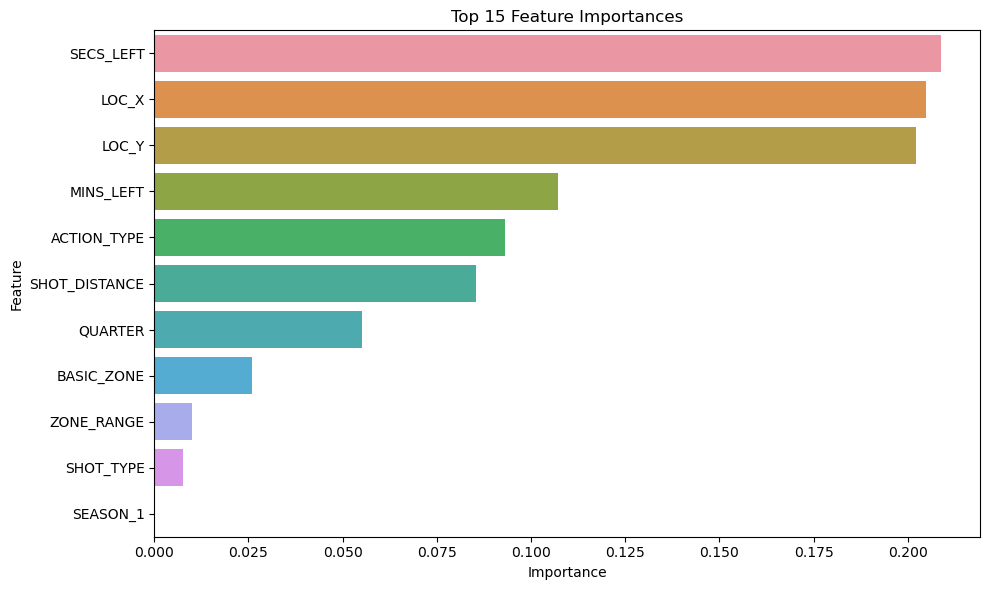

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [35]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.6 MB/s eta 0:00:0000:0100:01


In [37]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

from xgboost import XGBClassifier
from model_utils import evaluate_model

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
evaluate_model(y_test, y_pred_xgb)

/Users/tylertseng/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:01:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
[[18558  4462]
 [11977  8744]]

Classification Report:
              precision    recall  f1-score   support

       False       0.61      0.81      0.69     23020
        True       0.66      0.42      0.52     20721

    accuracy                           0.62     43741
   macro avg       0.63      0.61      0.60     43741
weighted avg       0.63      0.62      0.61     43741



In [38]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

y_pred_xgb = best_xgb.predict(X_test)

evaluate_model(y_test, y_pred_xgb)

print("Best hyperparameters:", grid_search.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Users/tylertseng/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:07:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tylertseng/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:07:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tylertseng/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:07:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tylertseng/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:07:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encode

Confusion Matrix:
[[18598  4422]
 [12009  8712]]

Classification Report:
              precision    recall  f1-score   support

       False       0.61      0.81      0.69     23020
        True       0.66      0.42      0.51     20721

    accuracy                           0.62     43741
   macro avg       0.64      0.61      0.60     43741
weighted avg       0.63      0.62      0.61     43741

Best hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


In [39]:
from collections import Counter
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]
print(scale_pos_weight)

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    subsample=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
evaluate_model(y_test, y_pred_xgb)

1.1074947601724927


/Users/tylertseng/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:52:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
[[17243  5777]
 [10750  9971]]

Classification Report:
              precision    recall  f1-score   support

       False       0.62      0.75      0.68     23020
        True       0.63      0.48      0.55     20721

    accuracy                           0.62     43741
   macro avg       0.62      0.62      0.61     43741
weighted avg       0.62      0.62      0.61     43741



In [40]:
top_features = ['SECS_LEFT', 'LOC_X', 'LOC_Y', 'MINS_LEFT', 'ACTION_TYPE', 'SHOT_DISTANCE', 'QUARTER']

X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

xgb_model_top = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    colsample_bytree=1.0, 
    learning_rate=0.1,
    max_depth=7, 
    n_estimators=200, 
    subsample=0.8,
    random_state=42
)

xgb_model_top.fit(X_train_top, y_train)
y_pred_top = xgb_model_top.predict(X_test_top)
print(classification_report(y_test, y_pred_top))


/Users/tylertseng/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:54:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

       False       0.61      0.81      0.69     23020
        True       0.66      0.42      0.52     20721

    accuracy                           0.63     43741
   macro avg       0.64      0.62      0.61     43741
weighted avg       0.63      0.63      0.61     43741



In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X_train_log = X_train[top_features]
X_test_log = X_test[top_features]

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_log, y_train)

y_pred_log = log_model.predict(X_test_log)

print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

[[14142  8878]
 [ 8656 12065]]
              precision    recall  f1-score   support

       False       0.62      0.61      0.62     23020
        True       0.58      0.58      0.58     20721

    accuracy                           0.60     43741
   macro avg       0.60      0.60      0.60     43741
weighted avg       0.60      0.60      0.60     43741



### Conclusion

This project used NBA shot data to predict whether a shot would be made or missed based on features such as location, shot distance, and time remaining. I trained both Logistic Regression and XGBoost models, comparing their performance.

- XGBoost achieved ~63% accuracy, outperforming Logistic Regression (~60%)
- Important features included `SECS_LEFT`, `LOC_X`, `LOC_Y`, and `MINS_LEFT`
- Feature importance helped identify what situational factors impact shot success

This project demonstrates my ability to:
- Clean and engineer features from raw sports data
- Build and tune machine learning models
- Interpret classification metrics and model outputs